# Deep Learning - Assigment 1

### Group Number: 22

### Teammates:
1. **Mahshid Jafar Tajrishi**
2. **Bar Melinarskiy**
3. **Cis van Aken**
4. **Simon van Klompenburg**

## Imports entire notebook

In [26]:
# Importing libraries
import pandas as pd
import numpy as np
from scipy.io import loadmat
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
torch.autograd.set_detect_anomaly(True)
from copy import deepcopy as dc
import random
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.interpolate import interp1d

## Global Definitions

In [27]:
# Path to the zip file
data_dir = "./Data"
data_path = f"{data_dir}/Xtrain.mat"
output_dir = "./Output"
model_dir = "./Models"
test_data_path = f"{data_dir}/Xtest.mat"

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

# Set a professional style for the plots
sns.set_theme(style="whitegrid")

model_name = "GRU_WITH_DROPOUT"
model_pth_path = f"{model_dir}/best_model_{model_name}.pth"
random.seed(42)

In [28]:
# Check if CUDA is available
print(torch.__version__)
print(torch.version.cuda)  # Should match CUDA 12.5
print(torch.backends.cudnn.version())  # Should return a version, not None
print(torch.cuda.is_available())  # Should return True

2.5.1
None
90100
True


### Utilities 

In [ ]:
def create_sequences(data, window_size, forecast_steps=1):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_steps + 1):
        X.append(data[i:i + window_size, 0])
        y.append(data[i + window_size:i + window_size + forecast_steps, 0])
    X = np.array(X).reshape(-1, window_size, 1)
    y = np.array(y).reshape(-1, forecast_steps)
    return X, y

def prepare_dataloader(series, window_size, batch_size=16):
    """
    Preprocess the datasets for the transformer model.

    Args:
        series: Array of numbers with the sequence of the laser measurements.
        window_size: Integer, the sliding window size.
        batch_size: The number of samples used in one forward and backward pass through the network.

    Returns:
        DataLoader, X, y
    """
    X, y = create_sequences(series, window_size)
    # Ensure proper shapes: X → (N, seq_len, input_dim), y → (N, input_dim)
    X_tensor = torch.tensor(X, dtype=torch.float32)  # Shape: (N, seq_len, input_dim)
    y_tensor = torch.tensor(y, dtype=torch.float32)  # Shape: (N, input_dim)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False), X_tensor, y_tensor

def train_model(model, train_loader, val_loader, attempt_index, epochs=20, lr=1e-3, teacher_forcing_prob=0.5, patience=25):
    """
    Train the given model with validation and return the final validation L1 loss.
    Includes early stopping based on validation loss.
    Logs all metrics (L1, MSE, MAE) for each epoch into a DataFrame.
    """
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    # Define loss functions
    huberLoss_criterion = nn.HuberLoss()  # Huber Loss
    mse_criterion = nn.MSELoss()  # MSE Loss
    mae_criterion = nn.L1Loss()  # MAE Loss (same as L1 Loss)

    best_val_loss = float('inf')
    best_model_state = model.state_dict()  # Initialize with the current model state
    no_improvement_epochs = 0  # Counter for early stopping

    # DataFrame to store metrics
    metrics_df = pd.DataFrame(columns=["trial_id", "epoch", "train_l1", "train_mse", "train_mae", "val_l1", "val_mse", "val_mae"])

    # Progress bar for epochs
    epochs_pbar = tqdm(range(epochs), desc=f"Trial: {attempt_index}", unit="epoch")

    for epoch in epochs_pbar:
        # Training phase
        model.train()
        running_train_huberLoss_loss = 0.0
        running_train_mse_loss = 0.0
        running_train_mae_loss = 0.0

        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            # Forward pass
            output = model(x_batch)

            # Apply teacher forcing
            if random.random() < teacher_forcing_prob:
                x_batch = x_batch.clone()  # Avoid in-place modification
                x_batch[:, -1, 0] = y_batch[:, 0]

            # Calculate loss
            huberLoss_loss = huberLoss_criterion(output, y_batch)
            mse_loss = mse_criterion(output, y_batch)
            mae_loss = mae_criterion(output, y_batch)

            running_train_huberLoss_loss += huberLoss_loss.item()
            running_train_mse_loss += mse_loss.item()
            running_train_mae_loss += mae_loss.item()

            # Backward pass
            optimizer.zero_grad()
            mae_loss.backward()
            optimizer.step()

        avg_train_huberLoss_loss = running_train_huberLoss_loss / len(train_loader)
        avg_train_mse_loss = running_train_mse_loss / len(train_loader)
        avg_train_mae_loss = running_train_mae_loss / len(train_loader)

        # Validation phase
        model.eval()
        running_val_huberLoss_loss = 0.0
        running_val_mse_loss = 0.0
        running_val_mae_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                x_batch, y_batch = batch[0].to(device), batch[1].to(device)
                output = model(x_batch)

                huberLoss_loss = huberLoss_criterion(output, y_batch)
                mse_loss = mse_criterion(output, y_batch)
                mae_loss = mae_criterion(output, y_batch)

                running_val_huberLoss_loss += huberLoss_loss.item()
                running_val_mse_loss += mse_loss.item()
                running_val_mae_loss += mae_loss.item()

        avg_val_huberLoss_loss = running_val_huberLoss_loss / len(val_loader)
        avg_val_mse_loss = running_val_mse_loss / len(val_loader)
        avg_val_mae_loss = running_val_mae_loss / len(val_loader)

        # Save metrics to DataFrame
        new_row = pd.DataFrame([{
            "trial_id": attempt_index,
            "epoch": epoch + 1,
            "train_HuberLoss": avg_train_huberLoss_loss,
            "train_MSE": avg_train_mse_loss,
            "train_MAE": avg_train_mae_loss,
            "val_HuberLoss": avg_val_huberLoss_loss,
            "val_MSE": avg_val_mse_loss,
            "val_MAE": avg_val_mae_loss
        }])
        metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

        # Save the best model
        if avg_val_mae_loss < best_val_loss:
            best_val_loss = avg_val_mae_loss
            best_model_state = model.state_dict()
            no_improvement_epochs = 0  # Reset early stopping counter
        else:
            no_improvement_epochs += 1  # Increment early stopping counter

        # Early stopping
        if no_improvement_epochs >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

        # Adjust learning rate
        scheduler.step(avg_val_mae_loss)

        # Update progress bar
        epochs_pbar.set_postfix(
            Train_huberLoss_Loss=avg_train_huberLoss_loss,
            Train_MSE_Loss=avg_train_mse_loss,
            Train_MAE_Loss=avg_train_mae_loss,
            Val_huberLoss_Loss=avg_val_huberLoss_loss,
            Val_MSE_Loss=avg_val_mse_loss,
            Val_MAE_Loss=avg_val_mae_loss,
        )

    # Load the best model
    model.load_state_dict(best_model_state)

    return best_val_loss, metrics_df  # Return the best validation L1 loss and metrics DataFrame

### Gated recurrent units (GRUs) RNN Model

In [30]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout=0.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.dropout = dropout

        self.gru = nn.GRU(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)
        self.dropout= nn.Dropout(dropout) if num_stacked_layers > 1 else 0.0

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(x.device)

        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out


### Load and Split the dataset into train-validation

In [31]:
# Define augmentation functions
def add_noise(x, std=0.002):
    return x + np.random.normal(0, std, size=x.shape)

def add_drift(x, strength=0.05):
    drift = np.linspace(0, strength, num=len(x)).reshape(-1, 1)
    return x + drift

def time_warp(x, stretch_factor=1.15):
    original_steps = np.arange(len(x))
    new_steps = np.linspace(0, len(x) - 1, int(len(x) * stretch_factor))
    warped = interp1d(original_steps, x.ravel(), kind='linear', fill_value="extrapolate")(new_steps)
    warped = warped[:len(x)]  # clip/pad to original size
    return warped.reshape(-1, 1)

# Define jittering function
def add_jitter(x, std=0.01):
    """
    Add small random perturbations (jitter) to the data.

    Args:
        x (np.ndarray): Input data.
        std (float): Standard deviation of the jitter.

    Returns:
        np.ndarray: Jittered data.
    """
    return x + np.random.normal(0, std, size=x.shape)

data = loadmat(data_path)
measurements = data['Xtrain']
# Check the shape of the data
print("Shape of measurements:", measurements.shape)

# Display the first few rows of the data
print(f"First 5 measurements: {measurements[:5]}")

print(f"measurements range: min={measurements.min()}, max={measurements.max()}")

# Creating sequences
max_window_size = 100  # Maximum window size
# Split data into training and validation sets
# size_of_test = 200 + max_window_size  # 200 steps for testing + window size
train_data = measurements
val_data = add_noise(measurements, std=0.02)  # Adding noise to the validation data
# train_data, val_data = measurements[:-size_of_test], measurements[-size_of_test:]

# Normalize the training data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = scaler.fit_transform(train_data)

# Normalize the validation data using the same scaler
val_data_normalized = scaler.transform(val_data)

# Creating sequences
train_dataset, val_dataset = train_data_normalized, val_data_normalized

print(f"Train shape: {train_dataset.shape}, Val shape: {val_dataset.shape}")
print(f"train_dataset range: min={train_dataset.min()}, max={train_dataset.max()}")
print(f"val_dataset range: min={val_dataset.min()}, max={val_dataset.max()}")

# load the test data
test_data = loadmat(test_data_path)
test_measurements = test_data['Xtest']
print("Shape of test measurements:", test_measurements.shape)
print(f"test_measurements range: min={test_measurements.min()}, max={test_measurements.max()}")
test_data_normalized = scaler.transform(test_measurements)
print(f"test_data_normalized range: min={test_data_normalized.min()}, max={test_data_normalized.max()}")
test_dataset = test_data_normalized


Shape of measurements: (1000, 1)
First 5 measurements: [[ 86]
 [141]
 [ 95]
 [ 41]
 [ 22]]
measurements range: min=2, max=255
Train shape: (1000, 1), Val shape: (1000, 1)
train_dataset range: min=0.0, max=1.0
val_dataset range: min=3.4459673829579512e-06, max=1.0001248610747473
Shape of test measurements: (200, 1)
test_measurements range: min=3, max=255
test_data_normalized range: min=0.003952569169960474, max=1.0


Training dataset plot saved to ./Output/train_dataset_plot.png


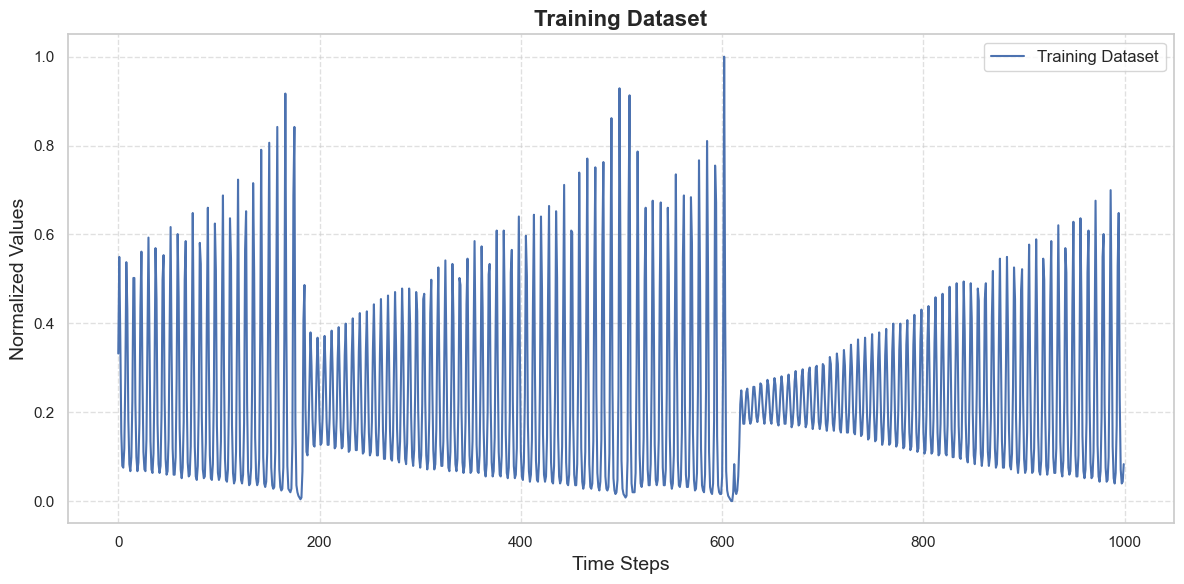

Validation dataset plot saved to ./Output/val_dataset_plot.png


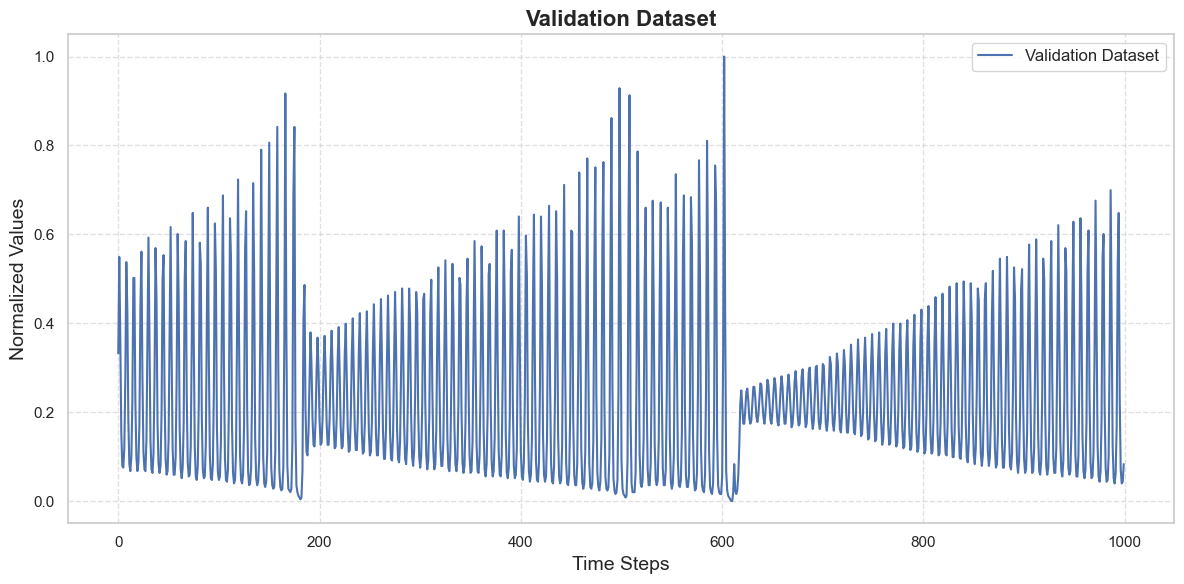

Test dataset plot saved to ./Output/test_dataset_plot.png


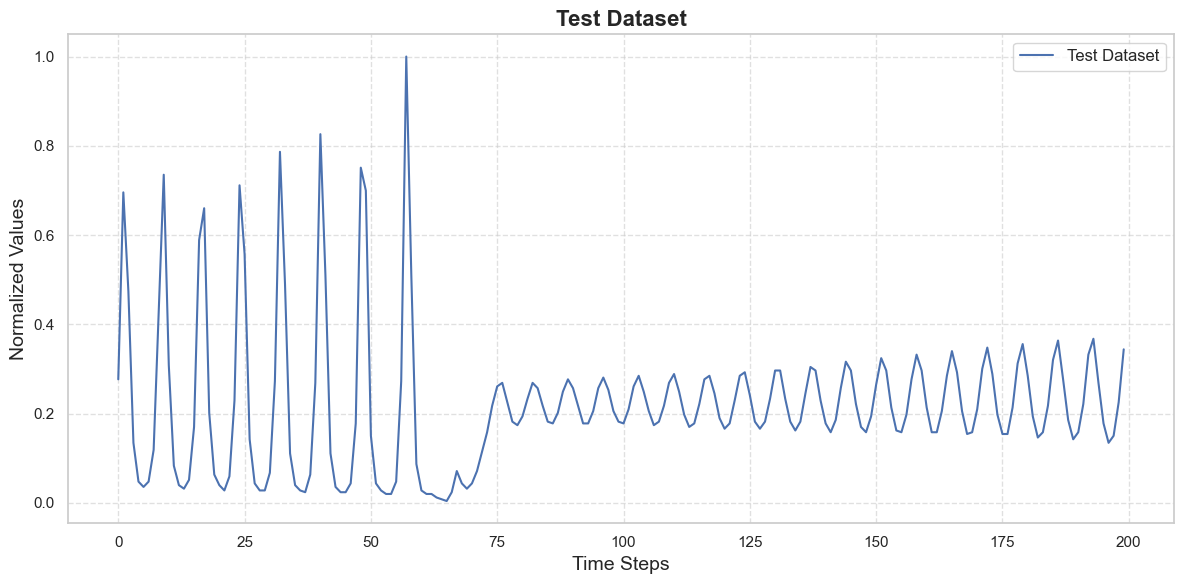

In [33]:
import matplotlib.pyplot as plt

def plot_dataset(dataset, dataset_name, save_path=None):
    """
    Plot a dataset with a given name.

    Args:
        dataset (np.ndarray): The dataset to plot (e.g., train, validation, or test).
        dataset_name (str): The name of the dataset (e.g., "Training", "Validation", "Test").
        save_path (str, optional): Path to save the plot. If None, the plot is not saved.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(dataset, label=f"{dataset_name} Dataset", linewidth=1.5)
    plt.xlabel("Time Steps", fontsize=14)
    plt.ylabel("Normalized Values", fontsize=14)
    plt.title(f"{dataset_name} Dataset", fontsize=16, weight="bold")
    plt.legend(fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)

    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=300)
        print(f"{dataset_name} dataset plot saved to {save_path}")

    plt.show()

# Example usage
plot_dataset(train_dataset, "Training", save_path=f"{output_dir}/train_dataset_plot.png")
plot_dataset(val_dataset, "Validation", save_path=f"{output_dir}/val_dataset_plot.png")
plot_dataset(test_dataset, "Test", save_path=f"{output_dir}/test_dataset_plot.png")

### Training the Model 

In [ ]:
best_model = None

# Initialize a global DataFrame to store metrics for all trials
all_metrics_df = pd.DataFrame(columns=["trial_id", "epoch", "train_HuberLoss", "train_MSE", "train_MAE", "val_HuberLoss", "val_MSE", "val_MAE", 
                                       "hidden_size", "num_layers", "learning_rate", "batch_size", "window_size"])

def objective(trial):
    global all_metrics_df  # Use the global DataFrame to store metrics

    # Suggest hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 128, 256, step=32)
    num_layers = trial.suggest_int('num_layers', 2, 10, step=2)
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    window_size = trial.suggest_int('window_size', 40, 100, step=10)
    dropout = trial.suggest_float('dropout', 0.1, 0.4, step=0.1) 

    # Update data loaders with the suggested batch size
    train_loader, train_X, train_y = prepare_dataloader(train_dataset, window_size, batch_size=batch_size)
    val_loader, val_X, val_y = prepare_dataloader(val_dataset, window_size, batch_size=batch_size)

    # Define the model
    model = GRU(
        input_size=1,  # Number of features in the input sequence
        hidden_size=hidden_size,
        num_stacked_layers=num_layers,
        dropout=dropout
    ).to(device)

    # Train the model and get the final validation loss and metrics DataFrame
    trial_index = trial.number + 1  # Start from 1 for better readability in logs
    val_loss, metrics_df = train_model(
        model, train_loader, val_loader, attempt_index=trial_index, epochs=200, lr=learning_rate
    )

    # Add trial parameters to the metrics DataFrame
    metrics_df["hidden_size"] = hidden_size
    metrics_df["num_layers"] = num_layers
    metrics_df["learning_rate"] = learning_rate
    metrics_df["batch_size"] = batch_size
    metrics_df["window_size"] = window_size
    metrics_df["dropout"] = dropout  # Log the dropout value


    # Save the best model
    if trial.number == 0 or val_loss < study.best_value:
        torch.save(model.state_dict(), model_pth_path)
        print(f"Best model saved with trial {trial.number}")
        best_model = model

        # Save the best hyperparameters
        with open(f"{model_dir}/best_hyperparameters_{model_name}.json", "w") as f:
            json.dump({
                "hidden_size": hidden_size,
                "num_layers": num_layers,
                "learning_rate": learning_rate,
                "batch_size": batch_size,
                "window_size": window_size,
                "dropout": dropout  
            }, f)

    # Append the metrics for this trial to the global DataFrame
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

    return val_loss  # Optuna will minimize this


# Create a study object
study = optuna.create_study(direction="minimize")  # Minimize validation loss

# Optimize the objective function
study.optimize(objective, n_trials=10)  # Run 100 trials

# Save the combined metrics DataFrame to a CSV file
csv_path = f"{output_dir}/all_trials_metrics_{model_name}.csv"
all_metrics_df.to_csv(csv_path, index=False)
print(f"All metrics saved to {csv_path}")

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Print the best validation loss
print("Best validation loss:", study.best_value)

# Load the best model
best_model = GRU(
    input_size=1,
    hidden_size=study.best_params['hidden_size'],
    num_stacked_layers=study.best_params['num_layers'],
    dropout = study.best_params['dropout']
).to(device)
best_model.load_state_dict(torch.load(model_pth_path))
print("Best model loaded.")

# Update train_loader and val_loader with the best hyperparameters
train_loader, train_X, train_y = prepare_dataloader(train_dataset, study.best_params['window_size'], batch_size=study.best_params['batch_size'])
val_loader, val_X, val_y = prepare_dataloader(val_dataset, study.best_params['window_size'], batch_size=study.best_params['batch_size'])
print("Data loaders updated with best hyperparameters.")

[I 2025-05-09 12:57:44,172] A new study created in memory with name: no-name-379d38ab-3178-48e7-b43c-14b790c00729


Trial: 1:   0%|          | 0/100 [00:00<?, ?epoch/s]

C:\Users\bar24\AppData\Local\Temp\ipykernel_14156\3716283863.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)
[I 2025-05-09 12:59:51,477] Trial 0 finished with value: 0.02566083268551477 and parameters: {'hidden_size': 160, 'num_layers': 6, 'lr': 3.730219080400616e-05, 'batch_size': 32, 'window_size': 100, 'dropout': 0.30000000000000004}. Best is trial 0 with value: 0.02566083268551477.


Best model saved with trial 0


Trial: 2:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:00:14,798] Trial 1 finished with value: 0.14123675202329952 and parameters: {'hidden_size': 224, 'num_layers': 10, 'lr': 0.009984775821671203, 'batch_size': 32, 'window_size': 40, 'dropout': 0.4}. Best is trial 0 with value: 0.02566083268551477.


Early stopping triggered after 15 epochs.


Trial: 3:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:01:06,638] Trial 2 finished with value: 0.006738374941051006 and parameters: {'hidden_size': 224, 'num_layers': 4, 'lr': 0.004735254770830136, 'batch_size': 128, 'window_size': 100, 'dropout': 0.30000000000000004}. Best is trial 2 with value: 0.006738374941051006.


Best model saved with trial 2


Trial: 4:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:01:35,918] Trial 3 finished with value: 0.0073867312477280695 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.005264224334238447, 'batch_size': 32, 'window_size': 70, 'dropout': 0.30000000000000004}. Best is trial 2 with value: 0.006738374941051006.


Early stopping triggered after 62 epochs.


Trial: 5:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:02:18,656] Trial 4 finished with value: 0.1431344932523267 and parameters: {'hidden_size': 192, 'num_layers': 6, 'lr': 0.007728515395692562, 'batch_size': 32, 'window_size': 100, 'dropout': 0.2}. Best is trial 2 with value: 0.006738374941051006.


Early stopping triggered after 13 epochs.


Trial: 6:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:04:25,647] Trial 5 finished with value: 0.1272444531064609 and parameters: {'hidden_size': 160, 'num_layers': 6, 'lr': 1.643356592713961e-05, 'batch_size': 32, 'window_size': 100, 'dropout': 0.2}. Best is trial 2 with value: 0.006738374941051006.


Trial: 7:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:04:53,294] Trial 6 finished with value: 0.13995155165421552 and parameters: {'hidden_size': 160, 'num_layers': 10, 'lr': 0.0006210884302879198, 'batch_size': 32, 'window_size': 90, 'dropout': 0.2}. Best is trial 2 with value: 0.006738374941051006.


Early stopping triggered after 17 epochs.


Trial: 8:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:05:14,064] Trial 7 finished with value: 0.13867814242839813 and parameters: {'hidden_size': 256, 'num_layers': 6, 'lr': 0.006927722537585905, 'batch_size': 32, 'window_size': 70, 'dropout': 0.1}. Best is trial 2 with value: 0.006738374941051006.


Early stopping triggered after 13 epochs.


Trial: 9:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:07:44,979] Trial 8 finished with value: 0.14262621384114027 and parameters: {'hidden_size': 192, 'num_layers': 10, 'lr': 4.652257685534379e-05, 'batch_size': 128, 'window_size': 80, 'dropout': 0.1}. Best is trial 2 with value: 0.006738374941051006.


Early stopping triggered after 40 epochs.


Trial: 10:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:08:17,266] Trial 9 finished with value: 0.015317537763621658 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0002578687329271592, 'batch_size': 128, 'window_size': 80, 'dropout': 0.4}. Best is trial 2 with value: 0.006738374941051006.


Trial: 11:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:09:17,016] Trial 10 finished with value: 0.008789934605980912 and parameters: {'hidden_size': 256, 'num_layers': 4, 'lr': 0.0013125542850718239, 'batch_size': 64, 'window_size': 50, 'dropout': 0.30000000000000004}. Best is trial 2 with value: 0.006738374941051006.


Trial: 12:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:09:33,389] Trial 11 finished with value: 0.009331022738479078 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.0018602237194047906, 'batch_size': 128, 'window_size': 60, 'dropout': 0.30000000000000004}. Best is trial 2 with value: 0.006738374941051006.


Trial: 13:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:10:04,606] Trial 12 finished with value: 0.010431255400180816 and parameters: {'hidden_size': 128, 'num_layers': 4, 'lr': 0.002428094063501869, 'batch_size': 64, 'window_size': 70, 'dropout': 0.30000000000000004}. Best is trial 2 with value: 0.006738374941051006.


Trial: 14:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:10:40,690] Trial 13 finished with value: 0.012995312019484118 and parameters: {'hidden_size': 224, 'num_layers': 4, 'lr': 0.00020850809012341358, 'batch_size': 128, 'window_size': 60, 'dropout': 0.4}. Best is trial 2 with value: 0.006738374941051006.


Trial: 15:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:11:12,042] Trial 14 finished with value: 0.006305940420133993 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0033605846303591627, 'batch_size': 128, 'window_size': 80, 'dropout': 0.30000000000000004}. Best is trial 14 with value: 0.006305940420133993.


Best model saved with trial 14


Trial: 16:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:12:02,819] Trial 15 finished with value: 0.012248249986441806 and parameters: {'hidden_size': 224, 'num_layers': 4, 'lr': 0.0006117109135835872, 'batch_size': 128, 'window_size': 90, 'dropout': 0.2}. Best is trial 14 with value: 0.006305940420133993.


Trial: 17:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:13:30,647] Trial 16 finished with value: 0.009016382071422413 and parameters: {'hidden_size': 256, 'num_layers': 8, 'lr': 0.0033264519601555916, 'batch_size': 128, 'window_size': 90, 'dropout': 0.4}. Best is trial 14 with value: 0.006305940420133993.


Trial: 18:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:14:51,959] Trial 17 finished with value: 0.010912893165368587 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0008600990574138123, 'batch_size': 128, 'window_size': 80, 'dropout': 0.30000000000000004}. Best is trial 14 with value: 0.006305940420133993.


Trial: 19:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:15:42,660] Trial 18 finished with value: 0.006147585692815483 and parameters: {'hidden_size': 224, 'num_layers': 4, 'lr': 0.0033785496929856157, 'batch_size': 128, 'window_size': 90, 'dropout': 0.2}. Best is trial 18 with value: 0.006147585692815483.


Best model saved with trial 18


Trial: 20:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:16:28,389] Trial 19 finished with value: 0.010989623873805006 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.001145076610883392, 'batch_size': 64, 'window_size': 80, 'dropout': 0.1}. Best is trial 18 with value: 0.006147585692815483.


Trial: 21:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:20:26,681] Trial 20 finished with value: 0.14347405079752207 and parameters: {'hidden_size': 192, 'num_layers': 8, 'lr': 0.00010046352848227807, 'batch_size': 128, 'window_size': 90, 'dropout': 0.2}. Best is trial 18 with value: 0.006147585692815483.


Early stopping triggered after 70 epochs.


Trial: 22:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:21:28,330] Trial 21 finished with value: 0.005823027720907703 and parameters: {'hidden_size': 224, 'num_layers': 4, 'lr': 0.003994689036478193, 'batch_size': 128, 'window_size': 100, 'dropout': 0.30000000000000004}. Best is trial 21 with value: 0.005823027720907703.


Best model saved with trial 21


Trial: 23:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:21:57,446] Trial 22 finished with value: 0.013725670170970261 and parameters: {'hidden_size': 224, 'num_layers': 4, 'lr': 0.003097870308794523, 'batch_size': 128, 'window_size': 100, 'dropout': 0.2}. Best is trial 21 with value: 0.005823027720907703.


Early stopping triggered after 47 epochs.


Trial: 24:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:22:48,754] Trial 23 finished with value: 0.00832028777222149 and parameters: {'hidden_size': 224, 'num_layers': 4, 'lr': 0.0020000786081797754, 'batch_size': 128, 'window_size': 90, 'dropout': 0.30000000000000004}. Best is trial 21 with value: 0.005823027720907703.


Trial: 25:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:24:18,481] Trial 24 finished with value: 0.006205552082974464 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.004393841162945671, 'batch_size': 128, 'window_size': 90, 'dropout': 0.2}. Best is trial 21 with value: 0.005823027720907703.


Trial: 26:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:27:11,418] Trial 25 finished with value: 0.012740803154883906 and parameters: {'hidden_size': 192, 'num_layers': 4, 'lr': 0.0004632816935039355, 'batch_size': 128, 'window_size': 90, 'dropout': 0.2}. Best is trial 21 with value: 0.005823027720907703.


Trial: 27:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:27:51,335] Trial 26 finished with value: 0.009914098478232821 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0013197245487324533, 'batch_size': 64, 'window_size': 100, 'dropout': 0.1}. Best is trial 21 with value: 0.005823027720907703.


Trial: 28:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:33:28,612] Trial 27 finished with value: 0.012134561489801854 and parameters: {'hidden_size': 192, 'num_layers': 8, 'lr': 0.004381401852867081, 'batch_size': 128, 'window_size': 90, 'dropout': 0.2}. Best is trial 21 with value: 0.005823027720907703.


Trial: 29:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:36:36,851] Trial 28 finished with value: 0.01683963811956346 and parameters: {'hidden_size': 192, 'num_layers': 4, 'lr': 0.0001539539883863406, 'batch_size': 128, 'window_size': 100, 'dropout': 0.2}. Best is trial 21 with value: 0.005823027720907703.


Trial: 30:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:36:50,048] Trial 29 finished with value: 0.13678552955389023 and parameters: {'hidden_size': 256, 'num_layers': 6, 'lr': 0.009672774648167601, 'batch_size': 128, 'window_size': 100, 'dropout': 0.1}. Best is trial 21 with value: 0.005823027720907703.


Early stopping triggered after 18 epochs.


Trial: 31:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:38:18,692] Trial 30 finished with value: 0.008253390543783705 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0019042192846990891, 'batch_size': 64, 'window_size': 80, 'dropout': 0.2}. Best is trial 21 with value: 0.005823027720907703.


Trial: 32:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:38:47,398] Trial 31 finished with value: 0.006106036918936297 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0031820843469870753, 'batch_size': 128, 'window_size': 80, 'dropout': 0.30000000000000004}. Best is trial 21 with value: 0.005823027720907703.


Trial: 33:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:39:18,245] Trial 32 finished with value: 0.005456862621940672 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0058839397090734635, 'batch_size': 128, 'window_size': 90, 'dropout': 0.30000000000000004}. Best is trial 32 with value: 0.005456862621940672.


Best model saved with trial 32


Trial: 34:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:39:25,995] Trial 33 finished with value: 0.01645588321844116 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.005655123385164165, 'batch_size': 128, 'window_size': 80, 'dropout': 0.30000000000000004}. Best is trial 32 with value: 0.005456862621940672.


Early stopping triggered after 26 epochs.


Trial: 35:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:40:16,523] Trial 34 finished with value: 0.00661368333385326 and parameters: {'hidden_size': 224, 'num_layers': 4, 'lr': 0.0027719919545868255, 'batch_size': 128, 'window_size': 90, 'dropout': 0.4}. Best is trial 32 with value: 0.005456862621940672.


Trial: 36:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:40:24,045] Trial 35 finished with value: 0.13470245711505413 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.009926710130637353, 'batch_size': 128, 'window_size': 100, 'dropout': 0.30000000000000004}. Best is trial 32 with value: 0.005456862621940672.


Early stopping triggered after 22 epochs.


Trial: 37:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:40:30,138] Trial 36 finished with value: 0.14316209871321917 and parameters: {'hidden_size': 256, 'num_layers': 6, 'lr': 0.0060690967578995465, 'batch_size': 128, 'window_size': 40, 'dropout': 0.30000000000000004}. Best is trial 32 with value: 0.005456862621940672.


Early stopping triggered after 14 epochs.


Trial: 38:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:41:42,939] Trial 37 finished with value: 0.006873106335600217 and parameters: {'hidden_size': 224, 'num_layers': 4, 'lr': 0.004667953908593163, 'batch_size': 32, 'window_size': 70, 'dropout': 0.30000000000000004}. Best is trial 32 with value: 0.005456862621940672.


Early stopping triggered after 62 epochs.


Trial: 39:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:42:35,997] Trial 38 finished with value: 0.14342230558395386 and parameters: {'hidden_size': 224, 'num_layers': 6, 'lr': 1.1157370100959992e-05, 'batch_size': 128, 'window_size': 90, 'dropout': 0.4}. Best is trial 32 with value: 0.005456862621940672.


Early stopping triggered after 85 epochs.


Trial: 40:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:43:22,243] Trial 39 finished with value: 0.010874136238647946 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.0009102683719555898, 'batch_size': 32, 'window_size': 100, 'dropout': 0.30000000000000004}. Best is trial 32 with value: 0.005456862621940672.


Early stopping triggered after 50 epochs.


Trial: 41:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:43:27,021] Trial 40 finished with value: 0.09700859989970922 and parameters: {'hidden_size': 224, 'num_layers': 4, 'lr': 0.007234646557440568, 'batch_size': 128, 'window_size': 80, 'dropout': 0.4}. Best is trial 32 with value: 0.005456862621940672.


Early stopping triggered after 11 epochs.


Trial: 42:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:44:21,048] Trial 41 finished with value: 0.008197030576411635 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.003927174918236882, 'batch_size': 128, 'window_size': 90, 'dropout': 0.2}. Best is trial 32 with value: 0.005456862621940672.


Early stopping triggered after 61 epochs.


Trial: 43:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:44:30,549] Trial 42 finished with value: 0.01217585866106674 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.004886826628671177, 'batch_size': 128, 'window_size': 90, 'dropout': 0.2}. Best is trial 32 with value: 0.005456862621940672.


Early stopping triggered after 35 epochs.


Trial: 44:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:46:08,511] Trial 43 finished with value: 0.010368432325776666 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0016798324455094414, 'batch_size': 128, 'window_size': 100, 'dropout': 0.30000000000000004}. Best is trial 32 with value: 0.005456862621940672.


Trial: 45:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:46:37,110] Trial 44 finished with value: 0.0067951650999020785 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0023890109183074787, 'batch_size': 128, 'window_size': 70, 'dropout': 0.30000000000000004}. Best is trial 32 with value: 0.005456862621940672.


Trial: 46:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:46:54,332] Trial 45 finished with value: 0.042690509866023886 and parameters: {'hidden_size': 224, 'num_layers': 4, 'lr': 0.006391416236496782, 'batch_size': 32, 'window_size': 90, 'dropout': 0.2}. Best is trial 32 with value: 0.005456862621940672.


Early stopping triggered after 13 epochs.


Trial: 47:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:48:15,752] Trial 46 finished with value: 0.06526336492970586 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 5.6146265621435363e-05, 'batch_size': 128, 'window_size': 80, 'dropout': 0.30000000000000004}. Best is trial 32 with value: 0.005456862621940672.


Trial: 48:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:48:54,540] Trial 47 finished with value: 0.006913128891028464 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.007498043554402078, 'batch_size': 128, 'window_size': 100, 'dropout': 0.2}. Best is trial 32 with value: 0.005456862621940672.


Trial: 49:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:50:21,976] Trial 48 finished with value: 0.005882850692917903 and parameters: {'hidden_size': 256, 'num_layers': 6, 'lr': 0.002638715133055262, 'batch_size': 64, 'window_size': 60, 'dropout': 0.30000000000000004}. Best is trial 32 with value: 0.005456862621940672.


Trial: 50:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-09 13:51:50,033] Trial 49 finished with value: 0.007470335609590014 and parameters: {'hidden_size': 256, 'num_layers': 6, 'lr': 0.0014034759694267363, 'batch_size': 64, 'window_size': 60, 'dropout': 0.30000000000000004}. Best is trial 32 with value: 0.005456862621940672.


All metrics saved to ./Output/all_trials_metrics_GRU_WITH_DROPOUT.csv
Best hyperparameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 0.0058839397090734635, 'batch_size': 128, 'window_size': 90, 'dropout': 0.30000000000000004}
Best validation loss: 0.005456862621940672
Best model loaded.
Data loaders updated with best hyperparameters.


C:\Users\bar24\AppData\Local\Temp\ipykernel_14156\3716283863.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_pth_path))


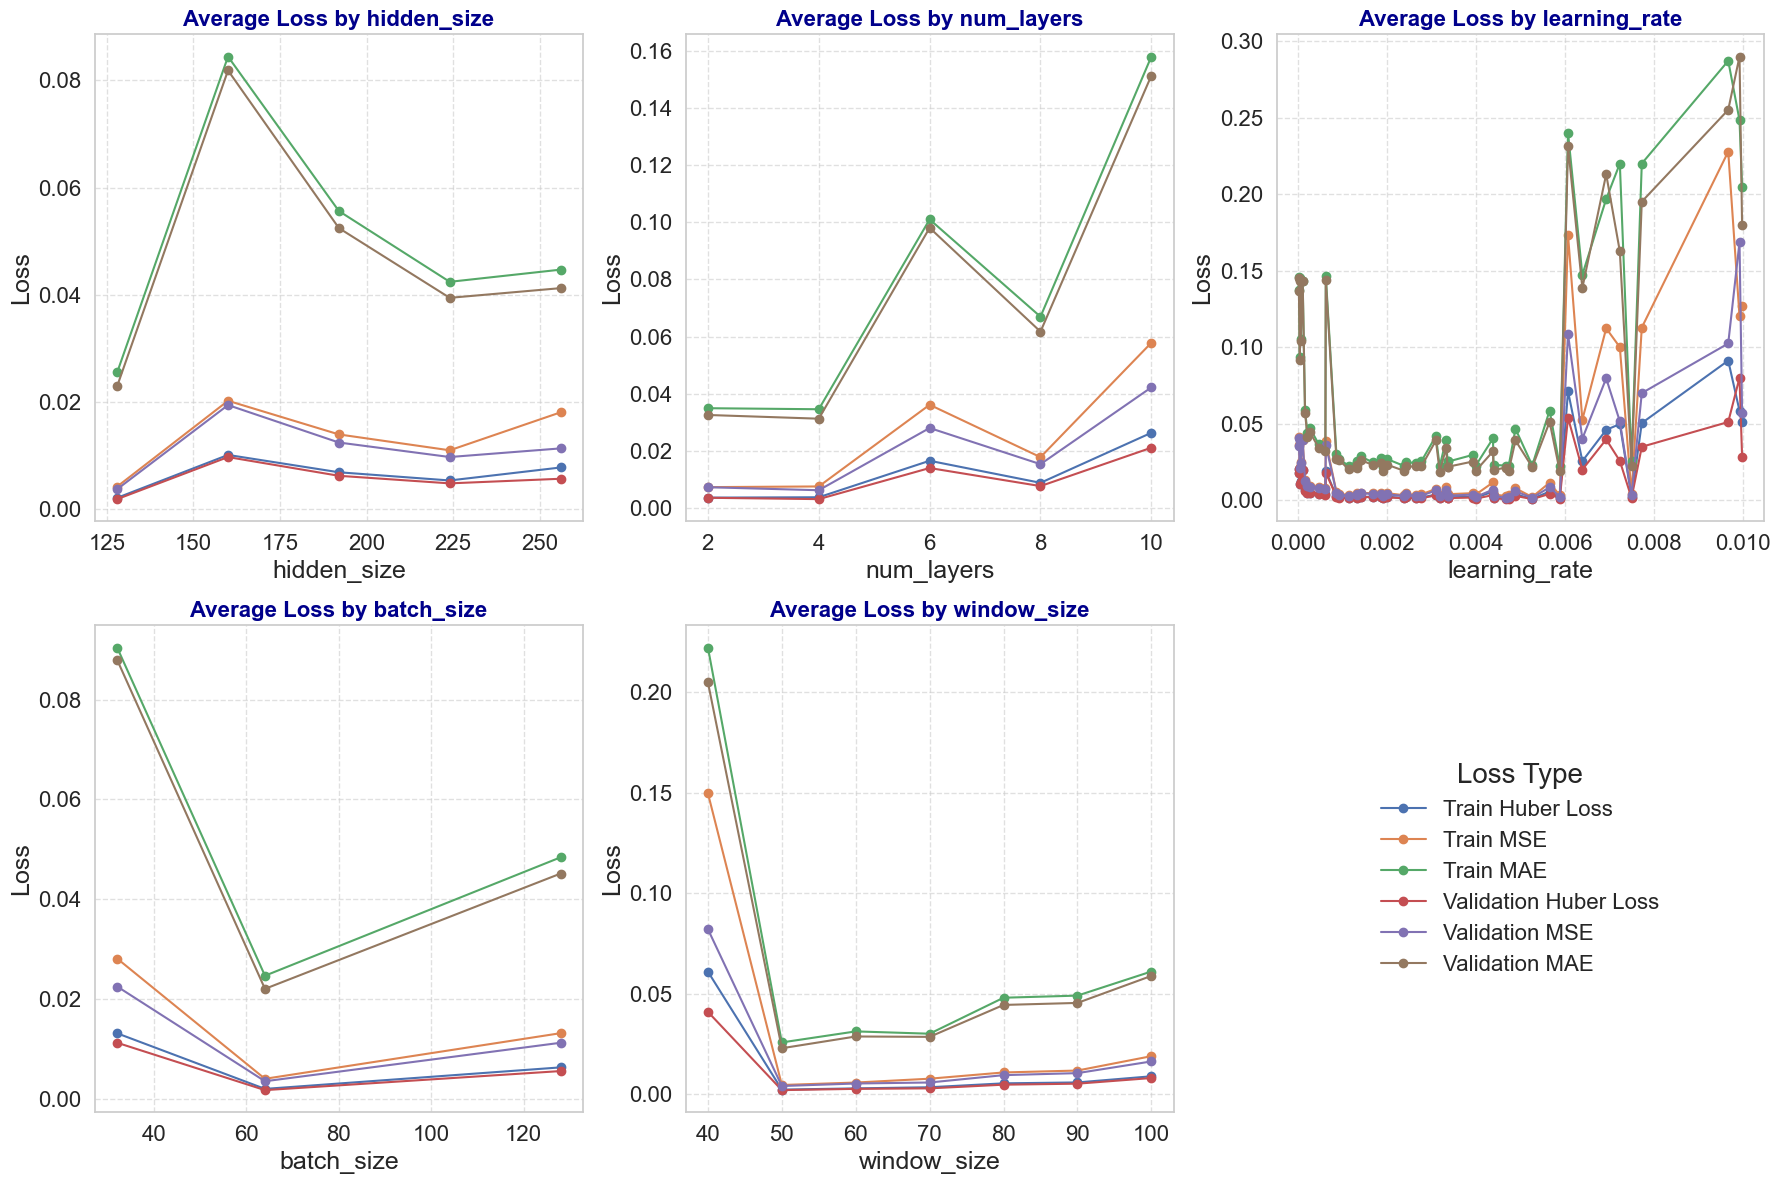

In [35]:
def plot_metrics_by_parameters(metrics_df, parameters, save_path):
    """
    Create a single figure with subplots for each parameter, showing average losses.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing trial metrics and parameters.
        parameters (list): List of parameters to plot (e.g., ['hidden_size', 'num_layers', 'dropout']).
    """
    # Mapping loss types to more readable names
    loss_type_mapping = {
        "train_HuberLoss": "Train Huber Loss",
        "train_MSE": "Train MSE",
        "train_MAE": "Train MAE",
        "val_HuberLoss": "Validation Huber Loss",
        "val_MSE": "Validation MSE",
        "val_MAE": "Validation MAE"
    }

    num_params = len(parameters)
    ncols = 3  # Number of columns
    nrows = (num_params + ncols - 1) // ncols  # Dynamically calculate rows based on parameters
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6 * nrows), sharex=False)

    # Flatten axes for easier iteration
    axes = axes.flatten()

    # Plot each parameter
    for i, (ax, parameter) in enumerate(zip(axes, parameters)):
        grouped = metrics_df.groupby(parameter).mean()  # Group by the parameter and calculate averages
        for loss, readable_name in loss_type_mapping.items():
            if loss in grouped.columns:
                ax.plot(grouped.index, grouped[loss], label=readable_name, marker='o', linestyle='-', linewidth=1.5)

        # Customize each subplot
        ax.set_xlabel(parameter, fontsize=18)
        ax.set_ylabel("Loss", fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_title(f"Average Loss by {parameter}", fontsize=16, weight='bold', color='darkblue')
        ax.grid(True, linestyle='--', alpha=0.6)

    # Remove unused subplots if parameters < nrows * ncols
    for j in range(len(parameters), len(axes)):
        if j == len(parameters):  # Use the first unused subplot for the legend
            handles, labels = ax.get_legend_handles_labels()
            axes[j].legend(
                handles, labels, loc="center", fontsize=16, title="Loss Type", title_fontsize=20, frameon=False
            )
            axes[j].set_axis_off()  # Turn off the axis for the legend plot
        else:
            fig.delaxes(axes[j])  # Remove any additional unused subplots

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

# Example: Plot average losses for all parameters in one figure
parameters_to_plot = ["hidden_size", "num_layers", "learning_rate", "batch_size", "window_size"]#, "dropout"]
plot_metrics_by_parameters(all_metrics_df, parameters_to_plot, f"{output_dir}/metrics_by_parameters_{model_name}.png")

### Predict the next 200 data points recursively

C:\Users\bar24\AppData\Local\Temp\ipykernel_14156\410383499.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_window = torch.tensor(val_X[0], dtype=torch.float32).to(device)


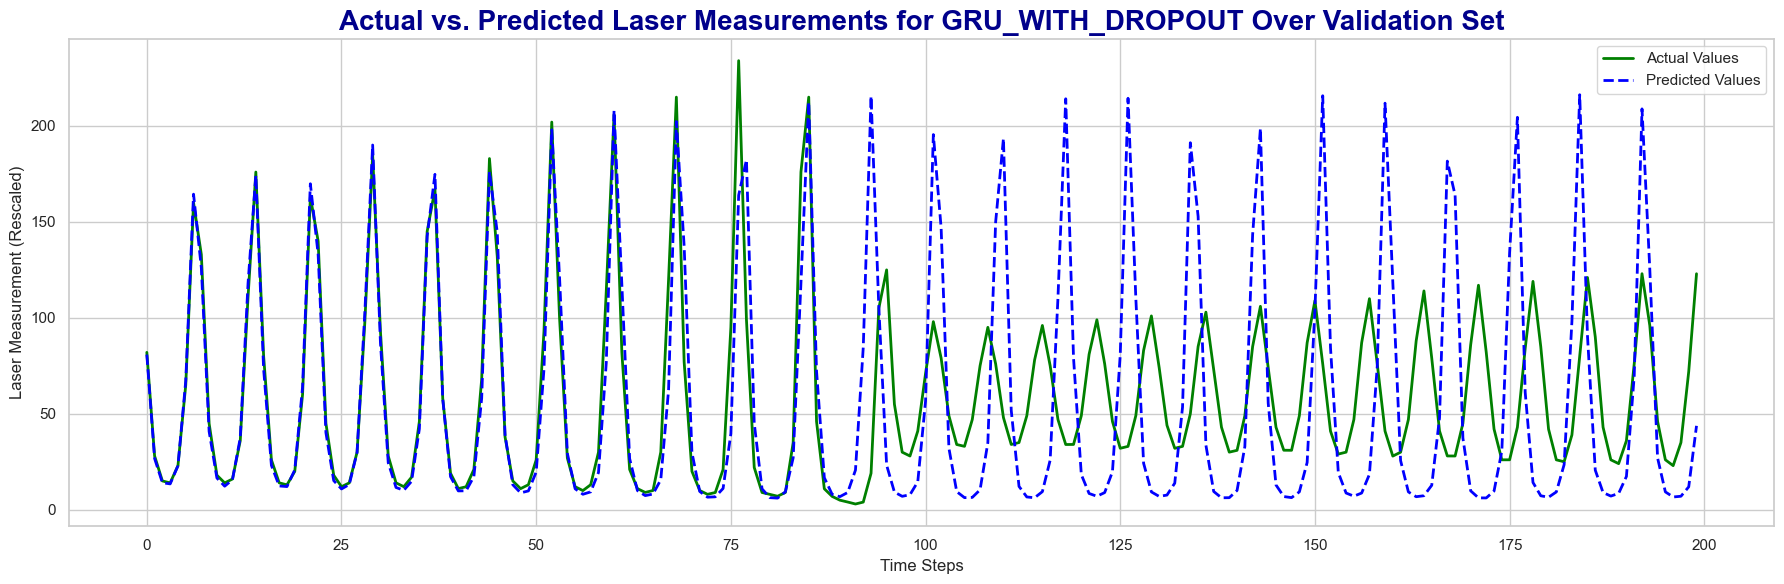

Metrics plot saved to ./Output/actual_vs_predicted_plot_GRU_WITH_DROPOUT_val.png


In [36]:
def predict_and_inverse_transform(model, init_window, scaler, steps=200):
    """
    Perform recursive forecasting using the trained model and convert predictions back to the original range.

    Args:
        model: The trained Gated recurrent units (GRUs) model.
        init_window: The initial sequence window (tensor) in normalized form.
        scaler: The MinMaxScaler used for normalization.
        steps: Number of forecasting steps.

    Returns:
        np.array: Forecasted values in the original range.
    """
    model.eval()
    preds = []
    current_seq = init_window.clone().to(device)  # Ensure the initial window is on the correct device

    with torch.no_grad():
        for step in range(steps):
            # Forward pass
            input = current_seq.unsqueeze(0).contiguous()  # Add batch dimension
            pred = model(input)  # shape: (1, seq_len, forecast_steps)

            # Extract the first predicted value
            pred_value = pred.item()  # Extract the first step of the forecast
            preds.append(pred_value)

            # Update the sequence by appending the prediction and removing the oldest value
            next_value = torch.tensor([[pred_value]], dtype=torch.float32, device=device)
            current_seq = torch.cat((current_seq[1:], next_value), dim=0)

    # Convert predictions to numpy array
    preds = np.array(preds).reshape(-1, 1)

    # Inverse transform the predictions to the original range
    preds_original = scaler.inverse_transform(preds)

    return preds_original

def plot_signals(predictions_rescaled, actual_values, save_path, daateset_name=""):
    """
    Plot training and validation metrics after training and compare predictions with actual values.
    """
    plt.figure(figsize=(18, 6))

    # Plot Actual vs Predicted Values
    plt.plot(actual_values, label="Actual Values", color="green", linewidth=2)
    plt.plot(predictions_rescaled, label="Predicted Values", color="blue", linestyle="--", linewidth=2)
    plt.xlabel("Time Steps")
    plt.ylabel("Laser Measurement (Rescaled)")
    plt.title(f"Actual vs. Predicted Laser Measurements for {model_name} Over {daateset_name}", fontsize=20, weight='bold', color='darkblue')
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"Metrics plot saved to {save_path}")
   
# Perform recursive forecasting to generate predictions
# Use the first sequence from the validation set as the initial window
init_window = torch.tensor(val_X[0], dtype=torch.float32).to(device)

# Predict and convert back to the original range
predicted_signal = predict_and_inverse_transform(best_model, init_window, scaler, steps=200)

# Compare with the actual values (also inverse transformed if needed)
actual_signal = scaler.inverse_transform(val_y[:len(predicted_signal)])

plot_signals(predicted_signal, actual_signal, f"{output_dir}/actual_vs_predicted_plot_{model_name}_val.png", "Validation Set")

### Load the trained model

In [ ]:
import json

def load_best_model():
    # Load the best hyperparameters
    with open(f"{model_dir}/best_hyperparameters_{model_name}.json", "r") as f:
        best_params = json.load(f)

    # Recreate the model with the best hyperparameters
    best_model = GRU(
        input_size=1,
        hidden_size=best_params['hidden_size'], 
        num_stacked_layers=best_params['num_layers'],
        dropout = best_params['dropout'] if 'dropout' in best_params else 0.0
    ).to(device)

    # Load the saved model weights
    best_model.load_state_dict(torch.load(model_pth_path))
    best_model.eval()

    return best_model, best_params

best_model, best_params = load_best_model()
print("Best hyperparameters are:", best_params)

# Update data loaders with the suggested batch size
window_size = best_params['window_size']
batch_size = best_params['batch_size']
train_loader, train_X, train_y = prepare_dataloader(train_dataset, window_size, batch_size=batch_size)
val_loader, val_X, val_y = prepare_dataloader(val_dataset, window_size, batch_size=batch_size)
test_loader, test_X, test_y = prepare_dataloader(test_dataset, window_size, batch_size=batch_size)

## Evaluate the model

In [37]:
import torch.nn as nn

def evaluate_model(best_model, val_loader, dataset_name):
    """
    Evaluate the best model on given dataset and calculate MSE and MAE using PyTorch loss functions.

    Args:
        best_model: The trained model.
        val_loader: The given dataset (normalized).

    Returns:
        mse: Mean Squared Error.
        mae: Mean Absolute Error.
    """
    # Switch the model to evaluation mode
    best_model.eval()

    # Define PyTorch loss functions
    mse_criterion = nn.MSELoss()
    mae_criterion = nn.L1Loss()

    # Collect predictions and ground truth
    total_mse = 0.0
    total_mae = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            output = best_model(x_batch)

            # Calculate losses
            mse = mse_criterion(output, y_batch).item()
            mae = mae_criterion(output, y_batch).item()

            # Accumulate losses
            total_mse += mse * x_batch.size(0)
            total_mae += mae * x_batch.size(0)
            num_samples += x_batch.size(0)

    # Calculate average losses
    avg_mse = total_mse / num_samples
    avg_mae = total_mae / num_samples

    print(f"For model: {model_name} - {dataset_name} Evaluation:")
    print(f"{dataset_name} MSE: {avg_mse}")
    print(f"{dataset_name} MAE: {avg_mae}")

    return avg_mse, avg_mae

# Evaluate the best model
mse, mae = evaluate_model(best_model, train_loader, "Training")
mse, mae = evaluate_model(best_model, val_loader, "Validation")
mse, mae = evaluate_model(best_model, test_loader, "Test")

For model: GRU_WITH_DROPOUT - Training Evaluation:
Training MSE: 0.0003939532206968979
Training MAE: 0.005817508822368396
For model: GRU_WITH_DROPOUT - Validation Evaluation:
Validation MSE: 0.0003935959977292901
Validation MAE: 0.005821119714016607
For model: GRU_WITH_DROPOUT - Test Evaluation:
Test MSE: 0.0011938216421445498
Test MAE: 0.009131502253668648


C:\Users\bar24\AppData\Local\Temp\ipykernel_14156\241660653.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_window = torch.tensor(test_X[0], dtype=torch.float32).to(device)


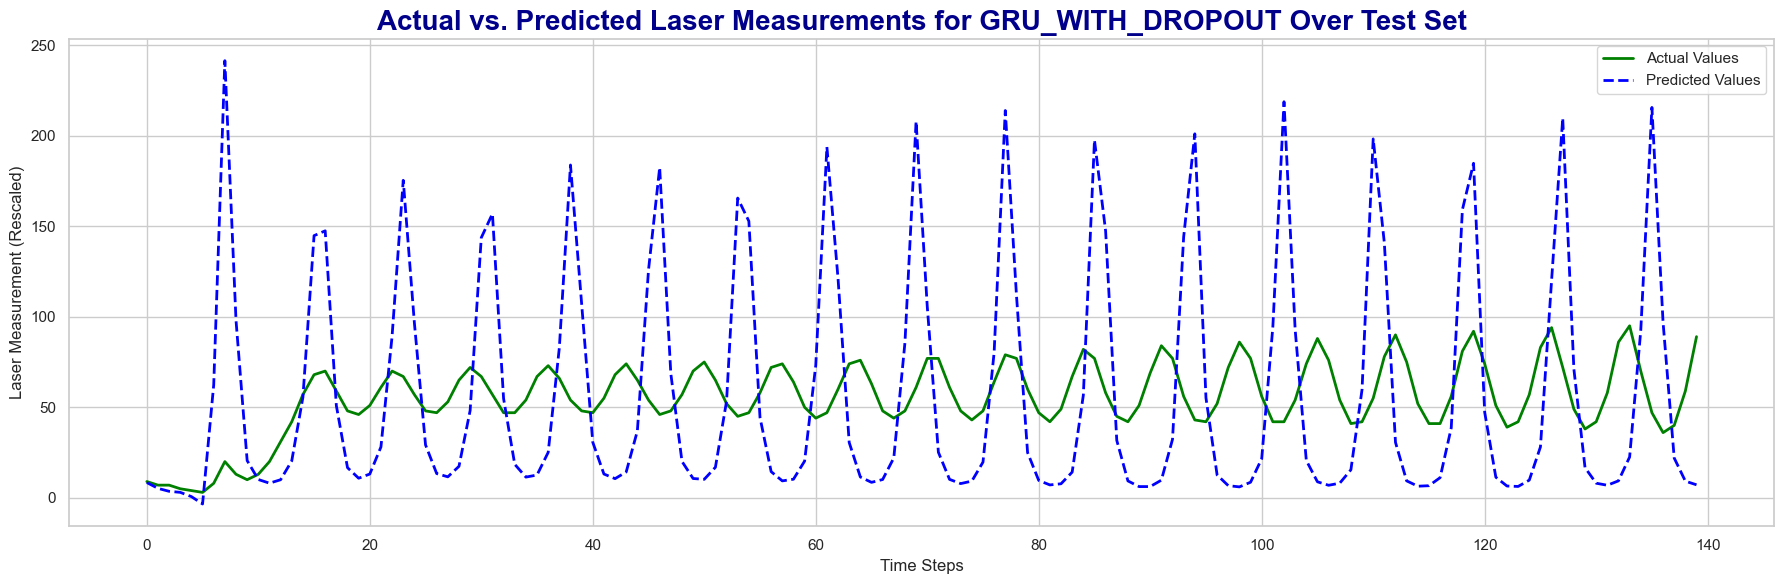

Metrics plot saved to ./Output/actual_vs_predicted_plot_GRU_WITH_DROPOUT_test.png


In [38]:
# Perform recursive forecasting to generate predictions
# Use the first sequence from the validation set as the initial window
init_window = torch.tensor(test_X[0], dtype=torch.float32).to(device)

# Predict and convert back to the original range
steps = 200 - window_size
predicted_signal = predict_and_inverse_transform(best_model, init_window, scaler, steps=steps)

# Compare with the actual values (also inverse transformed if needed)
actual_signal = scaler.inverse_transform(test_y[:len(predicted_signal)])

plot_signals(predicted_signal, actual_signal, f"{output_dir}/actual_vs_predicted_plot_{model_name}_test.png", "Test Set")

## Plot for results

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV files for RNN, LSTM, and GRU
rnn_metrics = pd.read_csv(f"{output_dir}/all_trials_metrics_RNN.csv")
lstm_metrics = pd.read_csv(f"{output_dir}/all_trials_metrics_LSTM.csv")
gru_metrics = pd.read_csv(f"{output_dir}/all_trials_metrics_GRU.csv")

# Add a column to identify the model
rnn_metrics["model"] = "RNN"
lstm_metrics["model"] = "LSTM"
gru_metrics["model"] = "GRU"

# Combine all metrics into a single DataFrame
all_metrics = pd.concat([rnn_metrics, lstm_metrics, gru_metrics], ignore_index=True)

# Define the parameters to plot
parameters_to_plot = ["hidden_size", "num_layers", "window_size", "batch_size"]

# Ensure all columns in parameters_to_plot are numeric and drop rows with NaN values
for param in parameters_to_plot:
    if param in all_metrics.columns:
        all_metrics[param] = pd.to_numeric(all_metrics[param], errors="coerce")
all_metrics = all_metrics.dropna(subset=parameters_to_plot)

# Define the loss functions to plot
loss_functions = {
    "MSE": ["train_MSE", "val_MSE"],
    "MAE": ["train_MAE", "val_MAE"]
}

# Define a mapping for paper-friendly parameter names
parameter_name_mapping = {
    "hidden_size": "Hidden Size",
    "num_layers": "Number of Layers",
    "window_size": "Window Size",
    "batch_size": "Batch Size"
}

# Replace parameter names in the parameters_to_plot list
parameters_to_plot = [parameter_name_mapping[param] for param in parameters_to_plot]

# Define colors for models
model_colors = {
    "RNN": ("blue", "darkblue"),
    "LSTM": ("mediumpurple", "purple"),
    "GRU": ("red", "darkred")
}

# Function to plot metrics for each loss function
# Function to plot metrics for each loss function
def plot_loss_metrics(metrics_df, loss_type, parameters, save_path):
    """
    Create a single figure with subplots for each parameter, showing average losses for train and validation.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing trial metrics and parameters.
        loss_type (str): The loss type to plot (e.g., "MSE", "MAE").
        parameters (list): List of parameters to plot (e.g., ['Hidden Size', 'Number of Layers', 'Window Size', 'Batch Size']).
        save_path (str): Path to save the plot.
    """
    loss_columns = loss_functions[loss_type]
    num_params = len(parameters)
    ncols = 2  # Number of columns
    nrows = (num_params + ncols - 1) // ncols  # Dynamically calculate rows based on parameters
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6 * nrows), sharex=False)

    # Flatten axes for easier iteration
    axes = axes.flatten()

    # Define markers for train and validation sets
    markers = {"train": "o", "val": "s"}  # Circle for train, square for validation
    linestyles = {"train": "-", "val": ":"}  # Solid for train, dotted for validation

    # Plot each parameter
    for i, (ax, parameter) in enumerate(zip(axes, parameters)):
        original_param = [key for key, value in parameter_name_mapping.items() if value == parameter][0]
        if original_param not in metrics_df.columns:
            continue  # Skip if the parameter is not in the DataFrame
        for model_name, model_df in metrics_df.groupby("model"):
            # Ensure the parameter column is numeric
            model_df[original_param] = pd.to_numeric(model_df[original_param], errors="coerce")
            model_df = model_df.dropna(subset=[original_param])  # Drop rows with NaN in the parameter column
            
            grouped = model_df.groupby(original_param).mean(numeric_only=True)  # Group by the parameter and calculate averages
            for loss_col, color in zip(loss_columns, model_colors[model_name]):
                if loss_col in grouped.columns:
                    # Determine marker type based on whether it's train or validation
                    marker_type = markers["train"] if "train" in loss_col else markers["val"]
                    linestyle_type = linestyles["train"] if "train" in loss_col else linestyles["val"]

                    label = f"{model_name} - {'Train' if 'train' in loss_col else 'Validation'}"
                    ax.plot(grouped.index, grouped[loss_col], label=label, color=color, marker=marker_type, linestyle=linestyle_type, linewidth=2.5)

        # Customize each subplot
        ax.set_xlabel(parameter, fontsize=18, color='royalblue', weight='bold')
        ax.set_ylabel(f"{loss_type} Loss", fontsize=18, color='royalblue', weight='bold')
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.set_title(f"{loss_type} Loss by {parameter}", fontsize=16, weight='bold', color='darkblue')
        ax.grid(True, linestyle='--', alpha=0.6)

        # Set x-axis ticks to the unique values of the parameter
        unique_values = sorted(metrics_df[original_param].unique())
        ax.set_xticks(unique_values)
        ax.set_xticklabels([str(int(val)) if val.is_integer() else f"{val:.2f}" for val in unique_values], rotation=45)

    # Remove unused subplots if parameters < nrows * ncols
    for j in range(len(parameters), len(axes)):
        fig.delaxes(axes[j])  # Remove any additional unused subplots

    # Add a legend to the right of the figure
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize=22, title="Model and Loss Type", title_fontsize=26)

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the legend
    plt.suptitle(f"{loss_type} Loss Metrics Across Models", fontsize=26, weight='bold')
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

# Generate plots for MSE and MAE
plot_loss_metrics(all_metrics, "MSE", parameters_to_plot, f"{output_dir}/MSE_loss_metrics_across_models.png")
plot_loss_metrics(all_metrics, "MAE", parameters_to_plot, f"{output_dir}/MAE_loss_metrics_across_models.png")